In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Predicting House Prices

In this project I want to practice the use of regression models (linear regression, ridge regression and lasso regression) and using decision trees to try to predict house prices based on information about a house.

The data can be found with detailed descriptions for the features at: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Loading the train and test data
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Making a new column in train and test sets to index them so they can be split later
train['key'] = 'train'
test['key'] = 'test'

# Joining the test and train data together
all_data = pd.concat([train, test]).reset_index(drop=True)

In [4]:
pd.set_option('display.max_columns', 500)
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,key
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,train


In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

Observations:
- We have 81 columns of which there are 37 numerical columns (not including `Id` column) and 44 categorical columns.
- There is an `Id` column which is redundant therefore can be removed.
- Lots of missing values that will have to be dealt with.

Lets have a look at our target variable which is `SalePrice`:

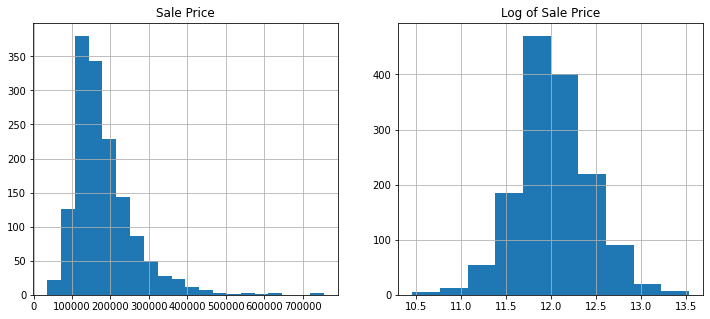

In [6]:
# Creating a variable that is just the target variable
target = train['SalePrice']

# Adding new column to train and all_data datasets which is the log of the sale price
train['LogSalePrice'] = np.log1p(train['SalePrice'])
all_data['LogSalePrice'] = np.log1p(train['SalePrice'])
target_log = train['LogSalePrice']

# Creating a plot to have histograms of `SalePrice` and `LogSalePrice` on same plot
fig = plt.figure(figsize=(12,5))

# Histogram subplot of `SalePrice`
plt.subplot(1,2,1)
target.hist(bins=20)
plt.title('Sale Price')

# Histogram subplot of `LogSalePrice`
plt.subplot(1,2,2)
target_log.hist()
plt.title('Log of Sale Price')

plt.show()


Here we can see the distribution for the target variables and the distrbution of the log of the target variable which results in a normalised distribution. We will use the log of sale price as our target variable.

# EDA

Now can perform exploratory data analysis on the train set to try to understand the data better and to start to look at which features may be useful in our model building.

### Numerical data

Lets look at the numerical data to see how it relates to our target variable.

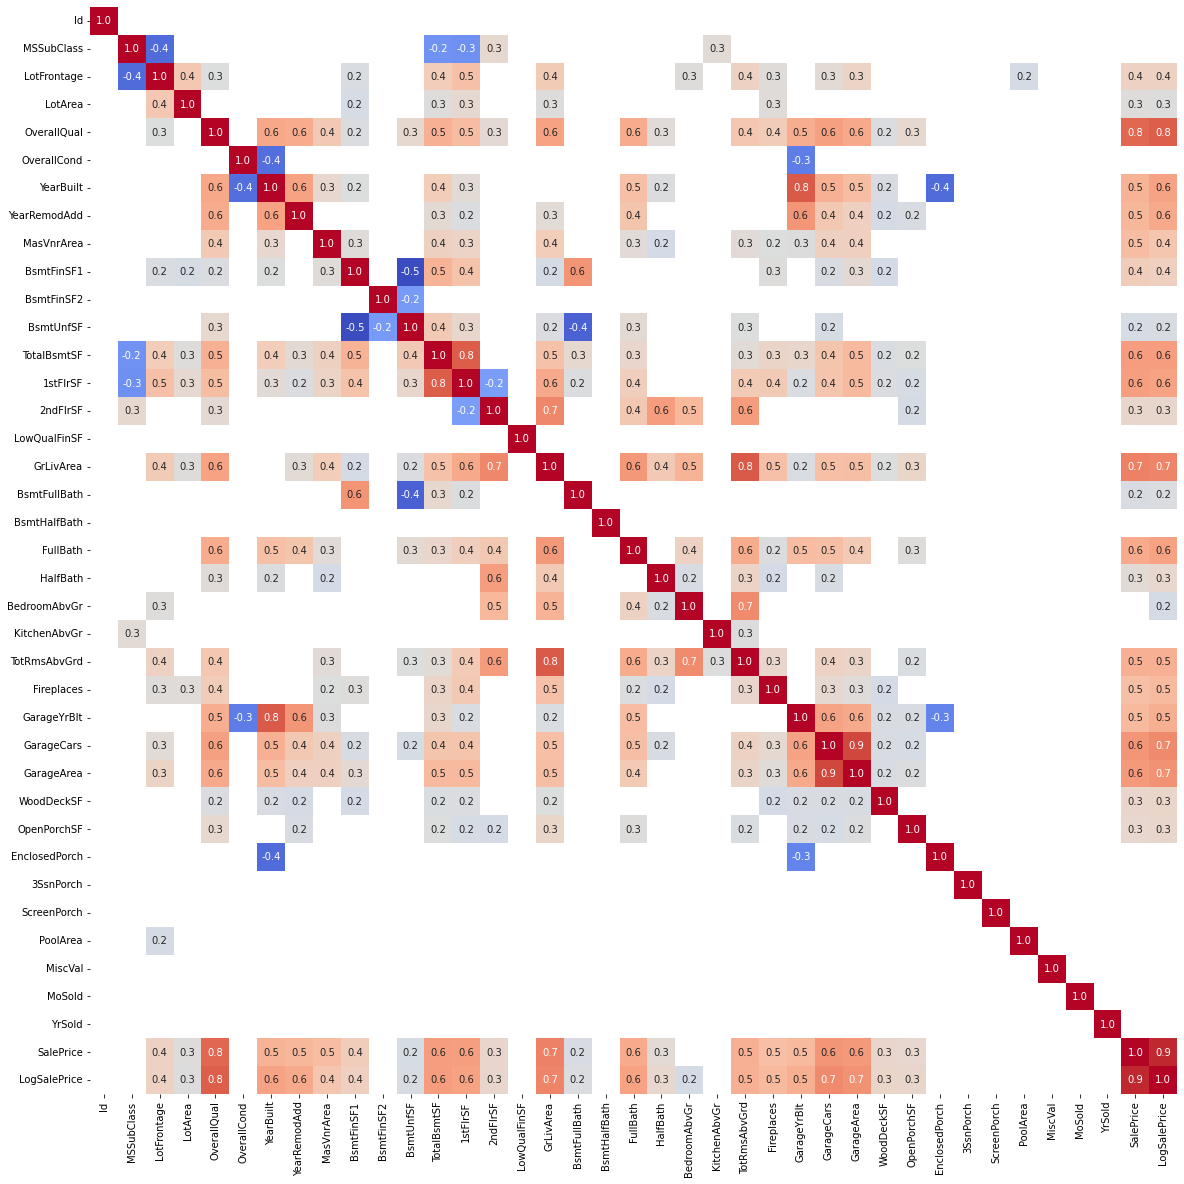

In [7]:
# Creating a heatmap to look at linear correlations between the columns
correlations = train.corr()
fig = plt.figure(figsize=(20,20))
sns.heatmap(correlations[abs(correlations) > 0.2], cmap='coolwarm', annot=True, fmt='.1f',square=True, cbar=False)
plt.show()

In [8]:
# Creating a list of numerical features identified from the heatmap as being correlated with target variable
numerical_predictors = correlations['SalePrice'][abs(correlations['SalePrice']) > 0.2].index
numerical_predictors = numerical_predictors.drop(['SalePrice', 'LogSalePrice'])
numerical_predictors = list(numerical_predictors)

## Categorical Data

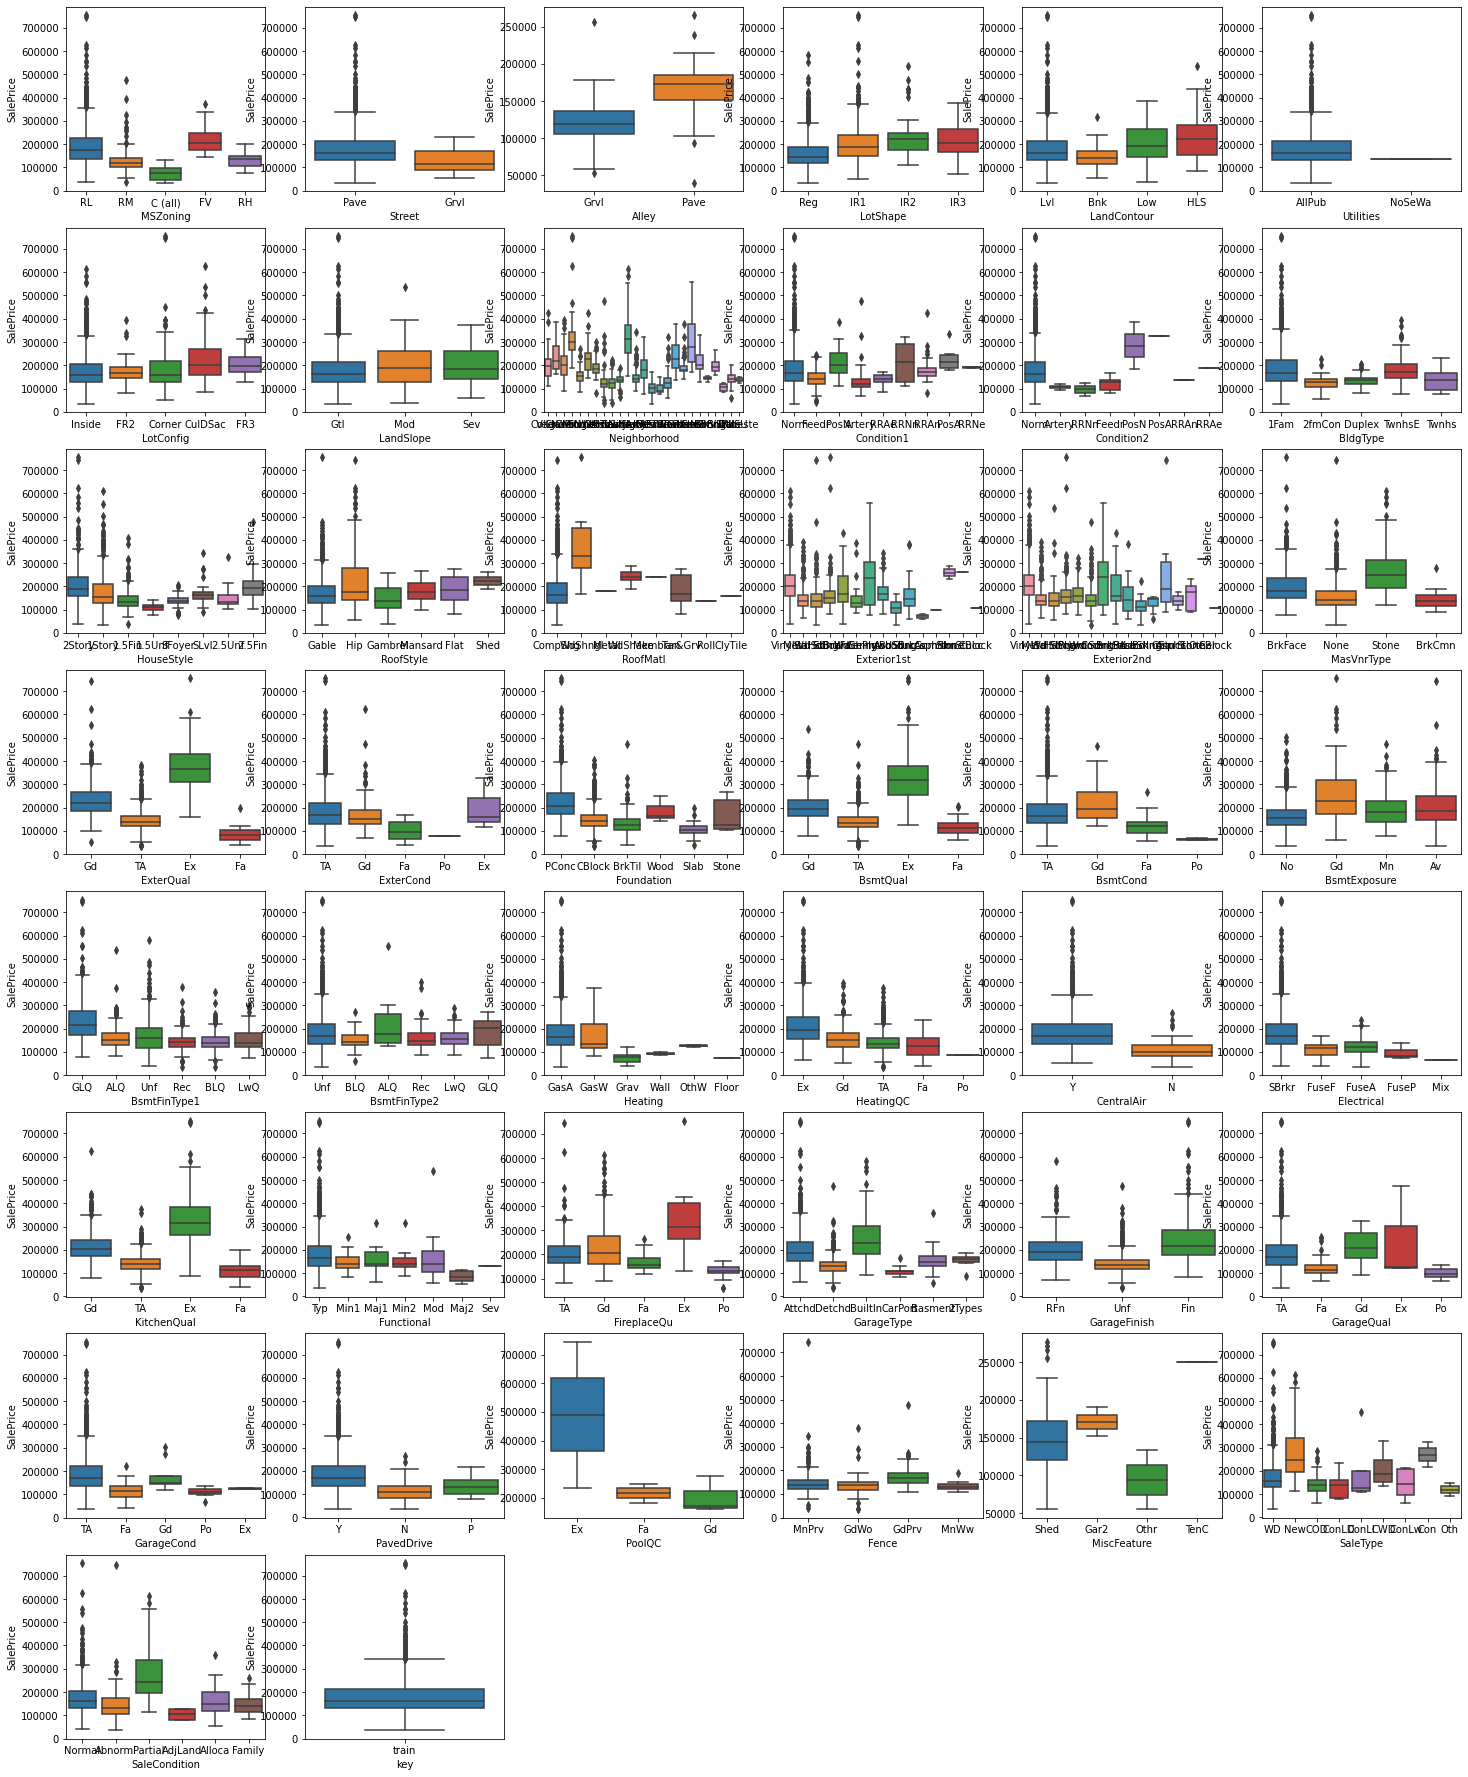

In [9]:
# Creating a list containing categorical column names
cat_cols = train.select_dtypes('object').columns

# Plotting a figure containing boxplots for categorical variables
fig = plt.figure(figsize=(25,40))

for ind, col in enumerate(cat_cols):
    plt.subplot(10,6,ind+1)
    sns.boxplot(data=train, x=col, y='SalePrice')


We can see some categorical variables where the different categories have quite different means:
- `Alley`, `Condition2` (don't know what this column refers to), `RoofMati`, `ExterQual`, `BsmtQual`... etc
- We can see some categories have a very low number of values. This makes it hard to use the feature in the model as it will likely overfit to categories with very few instances.
- For boxplots that represent the most popular category there are lots of outliers. This implies that very popular categories would b poor predictors of higher value properties

Lets make a list of possible categorical variables to use from these box plots. We will choose features that appears to have variations in boxplots for different categories but also appear to have a reasonable amount of data for each category,

In [10]:
# Creating a list of categorical features identified from the boxplots as possibly being relevant to the model
categorical_predictors = ['Alley', 'ExterQual', 'BsmtQual', 'CentralAir']
categorical_predictors

['Alley', 'ExterQual', 'BsmtQual', 'CentralAir']


## Missing Values

Lets look at the missing values in the entire dataset and work out how to deal with them.

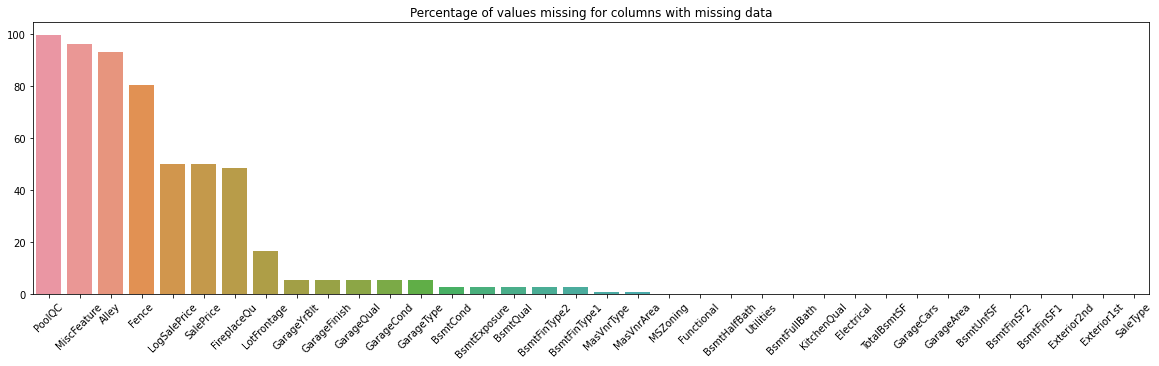

In [11]:
missing_features = all_data.isnull().sum()[all_data.isnull().sum() > 0] / all_data.shape[0] * 100
missing_features = missing_features.sort_values(ascending=False)
fig = plt.figure(figsize=(20,5))
ax = sns.barplot(y=missing_features, x=missing_features.index)
plt.title('Percentage of values missing for columns with missing data')
plt.xticks(rotation=45)
plt.show()


Observations:
- There are 4 columns with lots of missing data (80%+): `PoolQC`, `MiscFeature`, `Alley`, `Fence`.
- `LogSalePrice` and `SalePrice` can be ignored as the missing values come from the test set (as these are the target variable and its log form)
- There are 16 columns missing very little data (not even visible on the plot)

How to deal with missing data:
- Look at the source of the data to understand the columns better to know what the missing values could mean (ie: the lack of a certain characteristic in the property, genuine missing data etc)

In [12]:
missing_features.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'LogSalePrice', 'SalePrice',
       'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'GarageType', 'BsmtCond', 'BsmtExposure',
       'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea',
       'MSZoning', 'Functional', 'BsmtHalfBath', 'Utilities', 'BsmtFullBath',
       'KitchenQual', 'Electrical', 'TotalBsmtSF', 'GarageCars', 'GarageArea',
       'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'Exterior2nd', 'Exterior1st',
       'SaleType'],
      dtype='object')

In [13]:
# Missing data where missing value means the characteristic of the house doesn't exist, split into features that are categorical and numerical
lack_of_cat = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType',
    'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 
]

lack_of_num = [
    'LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtUnfSF',
    'BsmtFinSF2', 'BsmtFinSF1'
]

# Actual missing data (the property has this 'characteristic' but the data is missing in our dataset)
unfilled_data = ['MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Electrical', 'Exterior2nd', 'Exterior1st', 'SaleType']

The above lists are the columns with missing data seperated into different lists according to why the data is missing and therefore to how we can impute the missing data. The lists where made by looking at the information provided with the dataset which explains the different features.

The columns in `lack_of_cat` and `lack_of_num` are missing data because the property lacks the characteristic related to the feature, therefore for the categorical data we can inpute 'None' and for the numerical data we can impute 0.

The `unfilled_data` columns shows columns which have missing data not caused by the actual characteristics of the house but caused by some error along the process of data collection or subsequent mistakes causing data to be lost.

Lets explore further the `unfilled_data` columns to see if we can work out how to impute the missing data

In [14]:
data_missing_subset = all_data[unfilled_data]
data_missing_subset.isna().sum()

MSZoning       4
Functional     2
Utilities      2
KitchenQual    1
Electrical     1
Exterior2nd    1
Exterior1st    1
SaleType       1
dtype: int64

There isn't much missing data for these columns and they are all categorical. Lets look at some bar charts to see if there are any obvious ways to impute the missing data

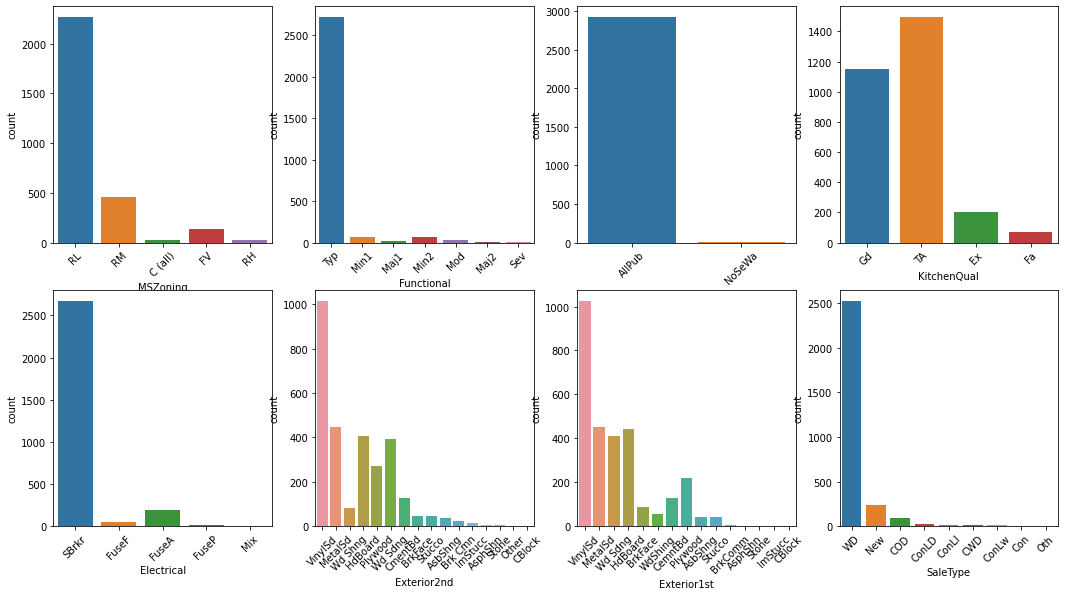

In [15]:
# Creating bar charts to show the different value frequences for features with missing data
fig = plt.figure(figsize=(18,20))

for ind, col in enumerate(unfilled_data):
    plt.subplot(4,4,ind+1)
    sns.countplot(data=all_data, x=col)
    plt.xticks(rotation=45)

plt.show()

Most features here have a clear column that has a much higher frequency than the rest, therefore we will just impute the mode for the missing values in all of these columns.

In [16]:
# Using sklearn imputer
from sklearn.impute import SimpleImputer

# For features with unfilled data imputing with the most common value for each feature
imp_most_frequent = SimpleImputer(strategy='most_frequent')
all_data[unfilled_data] = imp_most_frequent.fit_transform(all_data[unfilled_data])

# For categorical features with missing data due to lack of characterstic imputing with None
imp_none = SimpleImputer(strategy='constant', fill_value=None)
all_data[lack_of_cat] = imp_none.fit_transform(all_data[lack_of_cat])

# For numerical features with missing data due to lack of characterstic imputing with zero
imp_zero = SimpleImputer(strategy='constant', fill_value=0)
all_data[lack_of_num] = imp_zero.fit_transform(all_data[lack_of_num])


In [17]:
# Checking which features have missing data left
all_data.isnull().sum()[all_data.isnull().sum() > 0] 

SalePrice       1459
LogSalePrice    1459
dtype: int64

Now we only have missing values for the sale price related columns due to only having this information in the training data! We now have a cleaned dataset that we can use in our model building.

# Data Processing

Lets create a data processing pipeline that takes the dataframe, a list of predictors and the name of the target column. It then returns the test, train and validation data and creates dummy variables, scales the data and returns the data split into X and y datasets.

In [18]:
def data_processing(df, predictors, target):
    ### This function takes in all data and seperates it into train, test and validation sets with dummy variables
    
    
    predictors.append(target)
    df_all_columns = df[predictors].copy()
    df_all_columns['key'] = df['key']
    df_without_key = df_all_columns.drop(['key'], axis=1)
    df_dummies = pd.get_dummies(df_without_key)
    df_final = pd.concat([df['key'], df_dummies], axis=1)
    
    # Splitting final data into test and train sets
    train_data = df_final[df_final['key'] == 'train']
    test_data = df_final[df_final['key'] == 'test']

    # Splitting training set into predictors (X) and target (y)
    X_train = train_data.drop([target, 'key'], axis=1)
    y_train = train_data[target]

    # Splitting test set into predictors (X) and target (y)
    X_test = test_data.drop([target, 'key'], axis=1)
    y_test = test_data[target]

    # Creating a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
    
    # Scaling the training, validation and test data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    # X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val
    

## Baseline Model Building

Lets build an initial model using linear regression. The predictors for the model will be all the numerical columns we identified earlier as having more than a 0.2 absolute correlation with the target variable and a few selected categorical variables.

In [19]:
# Processing the data
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val = data_processing(
    df=all_data, target='LogSalePrice', predictors= (categorical_predictors + numerical_predictors)
)

In [20]:
# Instantiating the model and fitting it to the scaled training data
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [21]:
def train_val_scores(X_train, X_val, y_train, y_val):
    ### This function returns the RMSE, MSE and R2 values for the train and validation sets

    # Looking at the MSE, RMSE and R2 score for the training set
    train_pred = lr.predict(X_train)
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    train_r2 = r2_score(y_train, train_pred)
    print("  Training set: MSE is: {} and the RMSE is: {}. The R2 score is: {}".format(train_mse, train_rmse, train_r2))

    # Looking at the MSE, RMSE and R2 score for the validation set
    val_pred = lr.predict(X_val)
    val_mse = mean_squared_error(y_val, val_pred)
    val_rmse = mean_squared_error(y_val, val_pred, squared=False)
    val_r2 = r2_score(y_val, val_pred)
    print("Validation set: MSE is: {} and the RMSE is: {}. The R2 score is: {}".format(val_mse, val_rmse, val_r2))

    train_rmse_og_scale = mean_squared_error(np.exp(y_train), np.exp(train_pred), squared=False)
    val_rmse_og_scale = mean_squared_error(np.exp(y_val), np.exp(val_pred), squared=False)

    print('_'*100)
    print("The RMSE on original scale for train set is: {} and for val set is: {}".format(train_rmse_og_scale, val_rmse_og_scale))

In [22]:
# Finding the MSE, RMSE and R2 score for the train and validation sets
train_val_scores(X_train_scaled, X_val_scaled, y_train, y_val)

  Training set: MSE is: 0.018140930922159838 and the RMSE is: 0.13468827314268988. The R2 score is: 0.8886301313896241
Validation set: MSE is: 0.04332971346305632 and the RMSE is: 0.20815790511786075. The R2 score is: 0.7138015101076273
____________________________________________________________________________________________________
The RMSE on original scale for train set is: 23271.768398194454 and for val set is: 149512.98477270294


Here we can see that for our initial model the validation and train sets have very similar scores for MSE, RMSE and R2. This implies that the model is not overfitting to the training data as it performs well on unseen data.

We can see therefore that our model is accounting for roughly 85% of the variance in the validation set. 

We can also see that the RMSE on the original scale for the validation set is $30,823. This is the average error for each prediction.

In [23]:
test_prediction = lr.predict(X_test_scaled)
submission = pd.DataFrame({'Id': test.index+1461, 'SalePrice': np.expm1(test_prediction)})
submission.to_csv('submission.csv', index=False)
    
 


**Baseline model scores: R2 on validation set is 0.87. Submission score is: 0.15721, placed in top 63%**

Now we want to move on to try and improve the model. We will try to improve with:
- Feature engineering
- Trying other ML models

# Feature Engineering

Lets keep this simple and see how we can improve the model by feature engineering. I want to try:
- Taking the log of numerical columns that are skewed
- Using polynomial terms for 5 most relevant numerical features
- Grouping less common categorical categories (<10) into 'other' category

In [24]:
# Using the log of the skewed columns

from scipy.stats import skew

# Finding the column names for numerical features that are skewed
skewed_features = all_data[numerical_predictors].apply(lambda x: skew(x))
skewed_features = skewed_features[skewed_features > 0.6]
skewed_features = skewed_features.index

# Transforming the skewed data by taking the log of the feature
all_data[skewed_features] = np.log1p(all_data[skewed_features])
print(f'A total of {len(skewed_features)} features were log transformed')


A total of 14 features were log transformed


In [25]:
# Processing the data
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val = data_processing(
    df=all_data, target='LogSalePrice', predictors= (categorical_predictors + numerical_predictors)
)

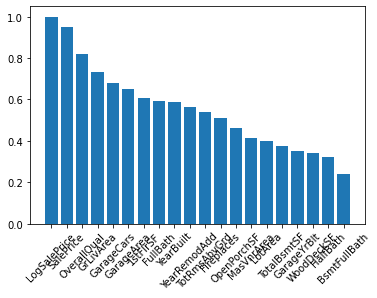

In [26]:
# Creating polynomial terms for most relevant numerical features

# Looking at which features have the highest linear correlation with target variable
correlations = all_data.corr()['LogSalePrice'].sort_values(ascending=False).head(20)
plt.bar(x=correlations.index, height=correlations)
plt.xticks(rotation=45)
plt.show()

In [27]:
# Isolating the top 10 features that have highest linear correlation with target variable 
# top_10_num = all_data.corr()['LogSalePrice'].sort_values(ascending=False).head(12).index

# Adding non-linear features to the dataset
# for feature in top_10_num[2:]:
  #  all_data[feature+'phalf'] = all_data[feature] ** 0.5
   # all_data[feature+'p2'] = all_data[feature] ** 2
    #all_data[feature+'p3'] = all_data[feature] ** 3
    #all_data[feature+'p4'] = all_data[feature] ** 4


In [28]:
# Grouping less common categories (with less than 10 instances) into 'other' category

low_num_categories = []
all_categorical_cols = all_data.select_dtypes('object').columns
for col in all_categorical_cols:
    df = pd.DataFrame(all_data[col].value_counts())
    if len(df[df[col]<10].index) > 0:
        for each in df[df[col]<10].index:
            low_num_categories.append(each)

In [29]:
for word in low_num_categories:
    all_data = all_data.replace(word, 'other')
    

In [30]:
# Looking at the different feature coefficients
#feature_importance = pd.DataFrame({'feature': X_train_scaled.columns, 'coefficient': model.coef_})
#feature_importance

### TODO:
- Tidy the project again, use functions to make running the model a lot easier
    - make one function that takes in the data and runs it on the model, returns scores and (depending on boolean input) submits the model.
- When finding the validation scores, run this multiple times on different val sets and report an average
- Do a feature analysis
- Look at feature engineering

### Improve Project
- Do a feature analysis
- Use lots of different models

### Questions
- How do you go about improving on model performance? Do you feature enginner or change the model you use (or which do you do first)?
- What parameters can you change for linear regression model?
- How should I structure projects so they feel less chaotic and so that each part of the project feels less dependent on other parts?
